In [2]:
import pandas as pd
import lightgbm
import numpy as np
import skopt

from src_clean.dataloader import DataLoader
from src_clean.preprocessor.prepro_new import PreprocessorTwo
from src_clean.ranker.ranker import Ranker
from src_clean.score.ndcg import calculate_ndcg

In [3]:
train_df = pd.read_parquet(f'train_df_preprocessed_WITH_normalization_outliers_change_pos.parquet')
test_df = pd.read_parquet(f'test_df_preprocessed_WITH_normalization_outliers_change_pos.parquet')

In [4]:
train_df = PreprocessorTwo.drop_cols(train_df, exclude_cols_to_drop=['srch_id', 'prop_id'])
test_df = PreprocessorTwo.drop_cols(test_df)

In [5]:
X_train, X_valid, y_train, y_valid = DataLoader.split_df_into_train_and_val_batches(train_df, validation_size=0.1)
group_train = [group.shape[0] for group in X_train]
group_val = [group.shape[0] for group in X_valid]

# Tuning

In [6]:
def train_evaluate(search_params):
    params = {'metric':'ndcg',
              'objective':'lambdarank',
              'bagging_freq': 1,
              'is_unbalance': False,
              'num_iterations': 500,
              'eval_at':5,
              **search_params}

    train_data = lightgbm.Dataset(np.vstack(X_train), label=np.hstack(y_train), group=group_train)
    valid_data = lightgbm.Dataset(np.vstack(X_valid), label=np.hstack(y_valid), reference=train_data, group=group_val)

    model = lightgbm.train(
        params=params,
        train_set=train_data,
        valid_sets=[valid_data],
        early_stopping_rounds=100,
        valid_names=['valid'],
    )

    best_score = model.best_score['valid']['ndcg@5']
    return best_score

In [7]:
SPACE = [
    skopt.space.Integer(7, 4095, name='num_leaves'),
    skopt.space.Integer(2, 100, name='max_depth'),
    skopt.space.Real(0.01, 5000, name='min_sum_hessian_in_leaf'),
    skopt.space.Real(0.4, 1, name='bagging_fraction'),
    skopt.space.Real(0.4, 1, name='feature_fraction'),
]

@skopt.utils.use_named_args(SPACE)
def objective(**params):
    return -1.0 * train_evaluate(params)

results = skopt.gp_minimize(objective, SPACE, n_calls=100, n_random_starts=10)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.539241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 45509
[LightGBM] [Info] Number of data points in the train set: 4463261, number of used features: 265
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid's ndcg@5: 0.316056
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid's ndcg@5: 0.353567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid's ndcg@5: 0.370857
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid's ndcg@5: 0.375935
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid's ndcg@5: 0.378509
[LightGBM] [Warning] No further splits with positive gain,

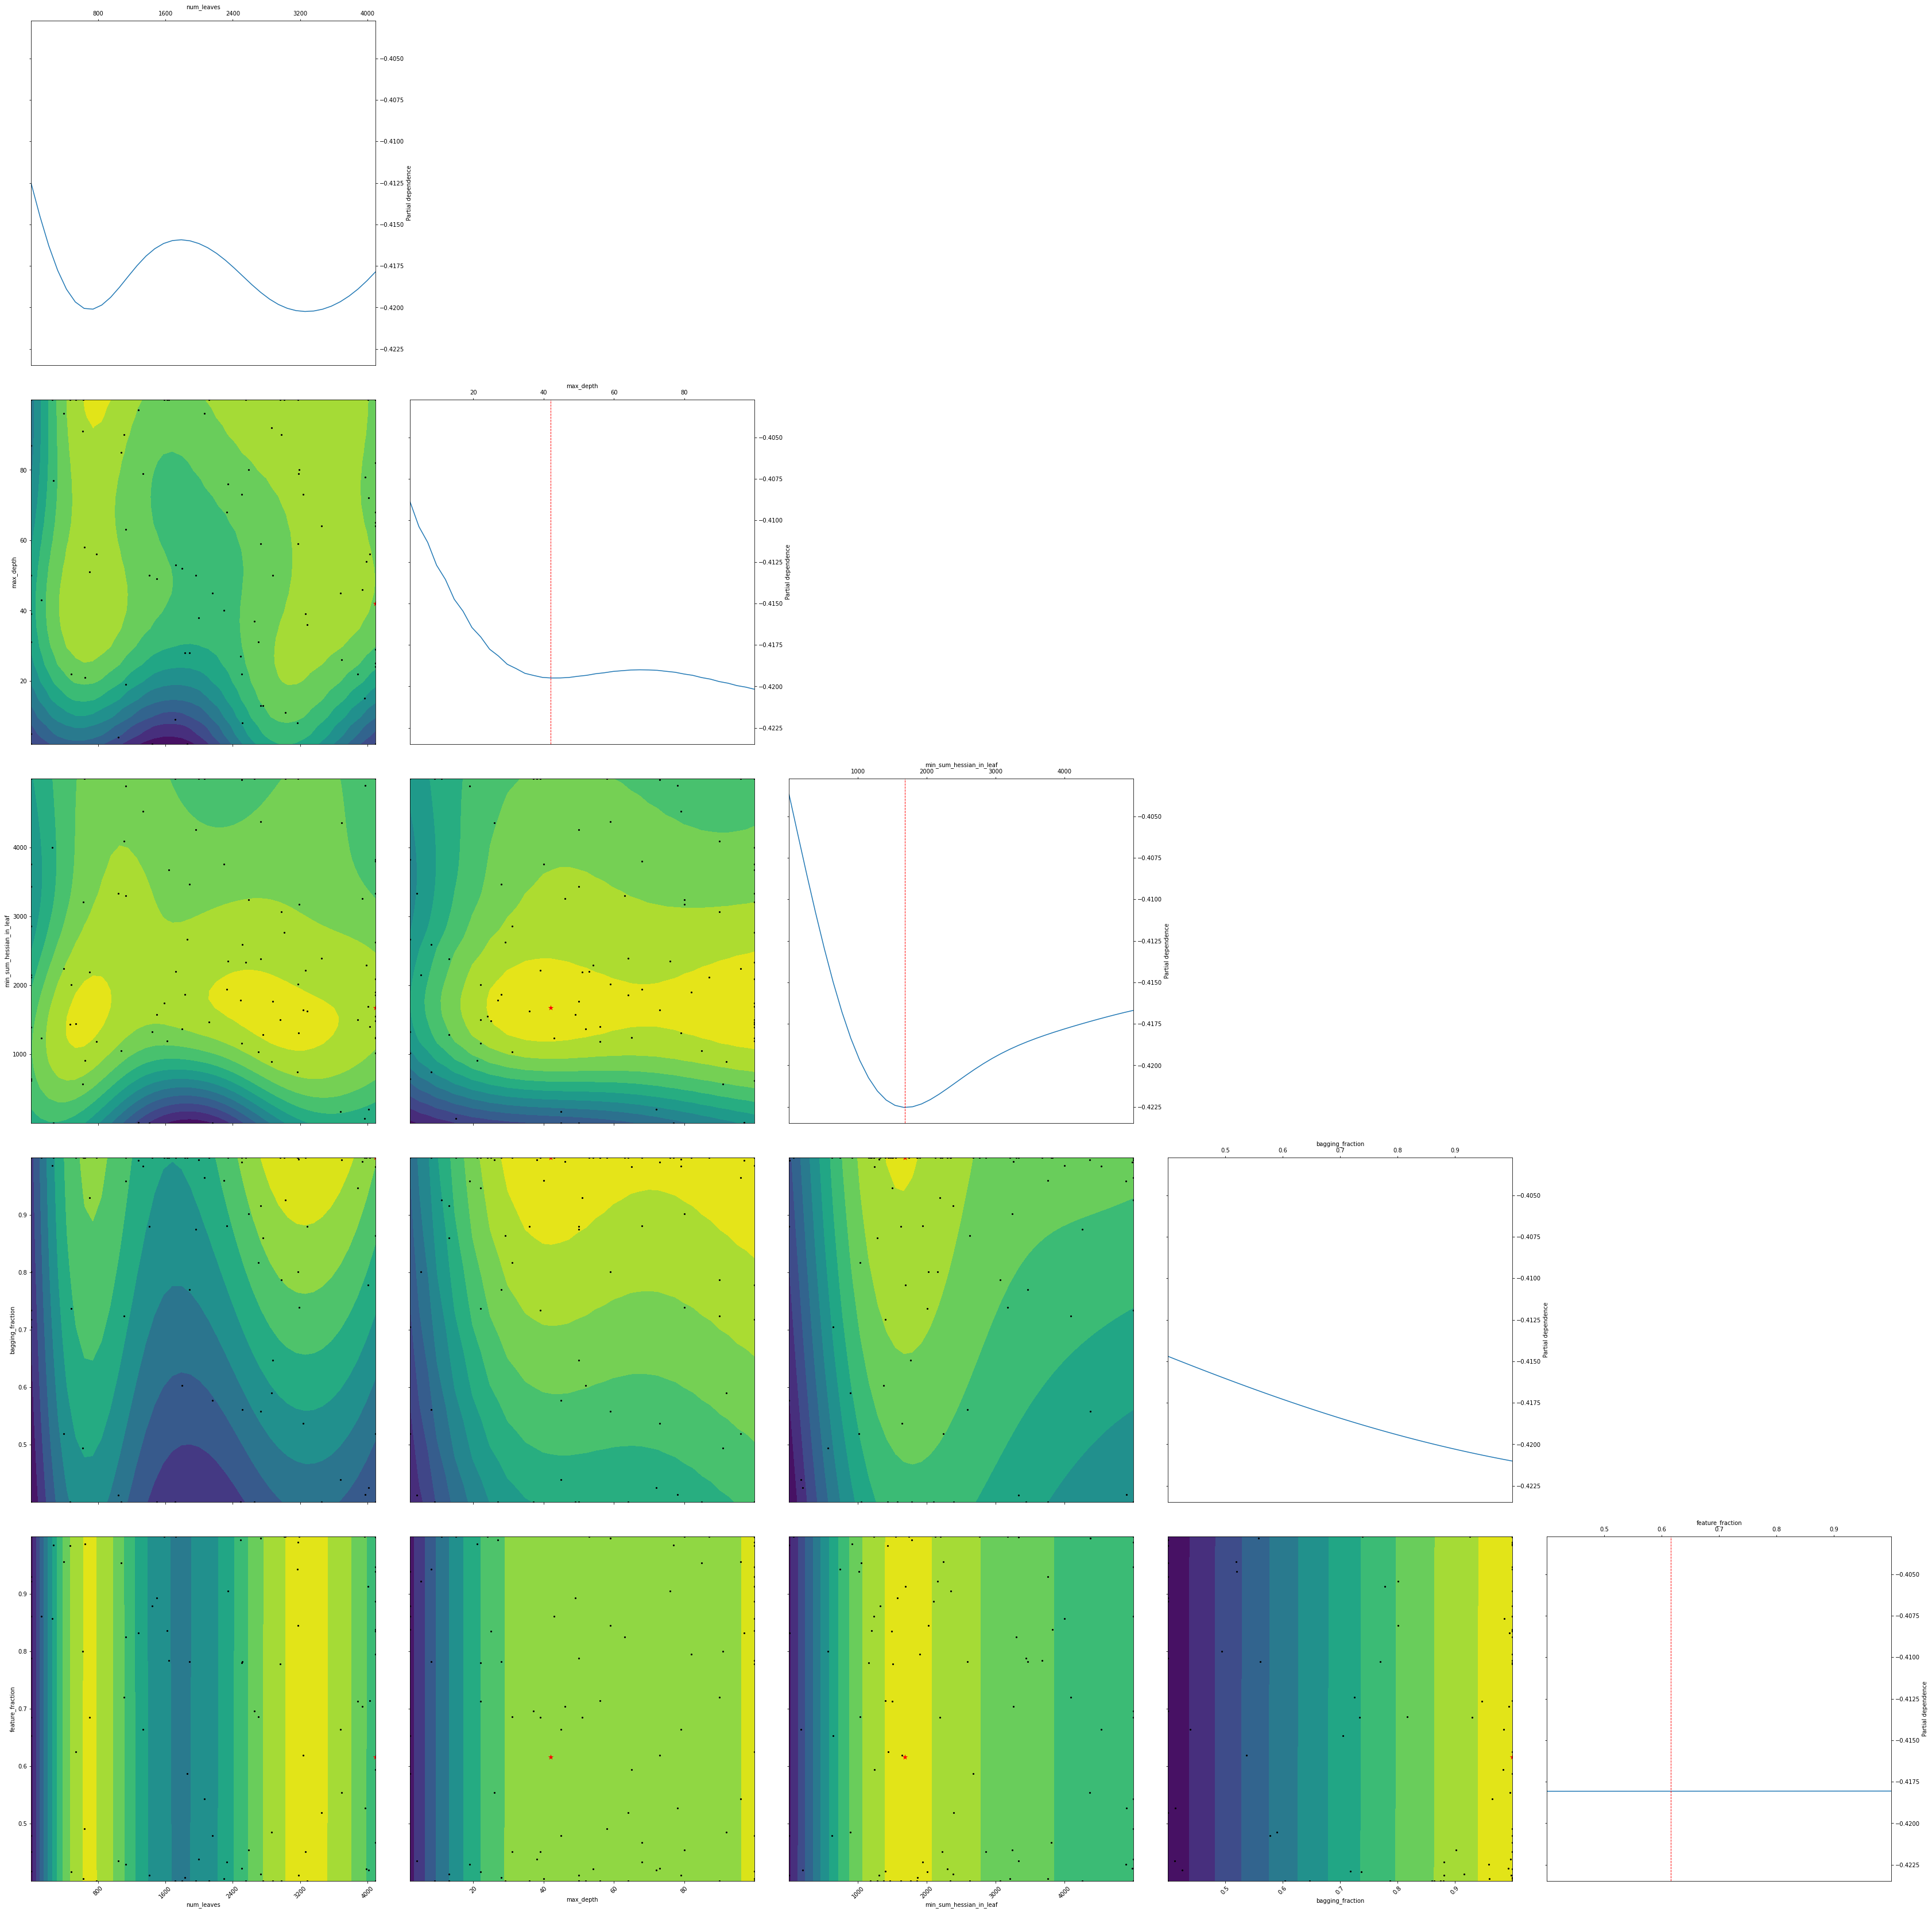

In [14]:
from skopt.plots import plot_objective
_ = plot_objective(results, size = 10)

In [8]:
def to_named_params(results, search_space):
    params = results.x
    param_dict = {}
    params_list  =[(dimension.name, param) for dimension, param in zip(search_space, params)]
    for item in params_list:
        param_dict[item[0]] = item[1]
    return param_dict
best_params = to_named_params(results, SPACE)
best_params

{'num_leaves': 4095,
 'max_depth': 42,
 'min_sum_hessian_in_leaf': 1678.407356592231,
 'bagging_fraction': 1.0,
 'feature_fraction': 0.6154980275926369}

In [10]:
results.fun

-0.4271147202574227

# Final model

In [55]:
params = {'num_iterations': 1000,
          'learning_rate': 0.047311784907414445,
          'max_depth': 500,
          'num_leaves': 272,
          'min_data_in_leaf': 9433,
          'n_estimators': 9999999,
          }

model = lightgbm.LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    early_stopping_round=100,
    **params
)
model.fit(
    X=np.vstack(X_train),
    y=np.hstack(y_train),
    group=group_train,
    eval_set=[(np.vstack(X_valid), np.hstack(y_valid))],
    eval_group=[group_val],
    eval_at=5,
    verbose=10
)

[LightGBM] [Warning] min_data_in_leaf is set=9433, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9433
[10]	valid_0's ndcg@5: 0.405087
[20]	valid_0's ndcg@5: 0.40662
[30]	valid_0's ndcg@5: 0.407862
[40]	valid_0's ndcg@5: 0.409883
[50]	valid_0's ndcg@5: 0.411195
[60]	valid_0's ndcg@5: 0.413353
[70]	valid_0's ndcg@5: 0.415433
[80]	valid_0's ndcg@5: 0.417681
[90]	valid_0's ndcg@5: 0.420327
[100]	valid_0's ndcg@5: 0.421864
[110]	valid_0's ndcg@5: 0.423084
[120]	valid_0's ndcg@5: 0.424395
[130]	valid_0's ndcg@5: 0.425458
[140]	valid_0's ndcg@5: 0.426274
[150]	valid_0's ndcg@5: 0.427064
[160]	valid_0's ndcg@5: 0.427903
[170]	valid_0's ndcg@5: 0.428348
[180]	valid_0's ndcg@5: 0.428953
[190]	valid_0's ndcg@5: 0.42941
[200]	valid_0's ndcg@5: 0.43103
[210]	valid_0's ndcg@5: 0.43129
[220]	valid_0's ndcg@5: 0.432092
[230]	valid_0's ndcg@5: 0.432022
[240]	valid_0's ndcg@5: 0.432583
[250]	valid_0's ndcg@5: 0.43297
[260]	valid_0's ndcg@5: 0.433643
[270]	valid_0's ndcg@5: 0.4337

LGBMRanker(early_stopping_round=100, learning_rate=0.047311784907414445,
           max_depth=500, metric='ndcg', min_data_in_leaf=9433,
           n_estimators=9999999, num_iterations=1000, num_leaves=272,
           objective='lambdarank')

In [56]:
pred = model.predict(test_df.to_numpy())
ranker = Ranker()
ranking_file_path = ranker.make_ranking_from_prediction(
    pred, model_name="LightGBM"
)
print(f"NDCG@5: {calculate_ndcg(ranking_file_path)}")
print(f"File path: {ranking_file_path}")

NDCG@5: 0.2846077269470295
File path: /Users/robinbux/Desktop/VU/Period5/DataMining/DMT_2022/Assignment_2/rankings/LightGBM/ranking_23_05_2022-11_22.csv


In [9]:
# train_df_preprocessed_no_normalization - score: NDCG@5: 0.2948800441842819
# train_df_preprocessed_no_normalization_outliers_removed - score: NDCG@5:  NDCG@5: 0.2846077269470295